In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from panda.utils.eval_utils import get_summary_metrics_dict
from panda.utils.plot_utils import (
    apply_custom_style,
    make_box_plot,
    plot_all_metrics_by_prediction_length,
)

apply_custom_style("../../config/plotting.yaml")

In [72]:
DEFAULT_COLORS = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [73]:
figs_save_dir = os.path.join("../../figures", "eval_metrics")
os.makedirs(figs_save_dir, exist_ok=True)

outputs_save_dir = os.path.join("../../outputs", "eval_metrics")
os.makedirs(outputs_save_dir, exist_ok=True)

In [74]:
WORK_DIR = os.getenv("WORK", "")
DATA_DIR = os.path.join(WORK_DIR, "data")

In [75]:
data_split = "test_zeroshot"

run_metrics_dir_dict = {
    "Panda": os.path.join(
        WORK_DIR,
        "eval_results",
        "patchtst",
        # "pft_stand_rff_only_pretrained-0",
        # "pft_chattn_noembed_pretrained_correct-0",
        "pft_chattn_emb_w_poly-0",
        # "pft_linattnpolyemb_from_scratch-0",
        data_split,
    ),
    # "Panda Univariate": os.path.join(
    #     WORK_DIR,
    #     "eval_results",
    #     "patchtst_univariate",
    #     # "pft_stand_rff_only_pretrained-0",
    #     # "pft_chattn_noembed_pretrained_correct-0",
    #     "pft_chattn_emb_w_poly-0",
    #     # "pft_linattnpolyemb_from_scratch-0",
    #     data_split,
    # ),
    "Dynamix": os.path.join(WORK_DIR, "eval_results", "dynamix", data_split),
    "Chronos 20M SFT": os.path.join(
        WORK_DIR,
        "eval_results",
        # "chronos_nondeterministic",
        # "chronos_sft",
        "chronos",
        "chronos_t5_mini_ft-0",
        data_split,
    ),
    "Chronos 46M SFT": os.path.join(WORK_DIR, "eval_results", "chronos", "chronos_small_ft_equalized-13", data_split),
    # "Chronos 20M": os.path.join(
    #     WORK_DIR,
    #     "eval_results",
    #     # "chronos_nondeterministic",
    #     "chronos",
    #     "chronos_mini_zeroshot",
    #     data_split,
    # ),
    # "Time MOE 50M": os.path.join(
    #     WORK_DIR,
    #     "eval_results",
    #     "timemoe",
    #     "timemoe-50m",
    #     data_split,
    # ),
    # "TimesFM 200M": os.path.join(
    #     WORK_DIR,
    #     "eval_results",
    #     "timesfm",
    #     "timesfm-200m",
    #     data_split,
    # ),
    "Chronos 200M": os.path.join(
        WORK_DIR,
        "eval_results",
        "chronos",
        # "chronos_nondeterministic",
        "chronos_base_zeroshot",
        data_split,
    ),
    "Chronos 200M Probabilistic": os.path.join(
        WORK_DIR,
        "eval_results",
        # "chronos",
        "chronos_nondeterministic",
        "chronos_base_zeroshot",
        data_split,
    ),
    # "Mean": os.path.join(
    #     WORK_DIR,
    #     "eval_results",
    #     "baselines",
    #     "mean",
    #     data_split,
    # ),
    # "Fourier": os.path.join(
    #     WORK_DIR,
    #     "eval_results",
    #     "baselines",
    #     "fourier",
    #     data_split,
    # ),
}

In [77]:
def parse_metric_lists(metrics_df: pd.DataFrame) -> pd.DataFrame:
    def parse_value(value):
        if isinstance(value, str):
            stripped = value.strip()
            if stripped.startswith("[") and stripped.endswith("]"):
                inner = stripped[1:-1].strip()
                if inner == "":
                    return []
                tokens = [token.strip() for token in inner.split(",")]
                parsed_vals = []
                for token in tokens:
                    if token == "":
                        continue
                    lowered = token.lower()
                    if lowered == "nan":
                        parsed_vals.append(np.nan)
                    elif lowered in {"inf", "+inf"}:
                        parsed_vals.append(np.inf)
                    elif lowered == "-inf":
                        parsed_vals.append(-np.inf)
                    else:
                        parsed_vals.append(float(token))
                return parsed_vals
        return value

    parsed = metrics_df.copy()
    for column in parsed.columns:
        if column == "system":
            continue
        parsed[column] = parsed[column].apply(parse_value)
    return parsed


def aggregate_system_metrics(metrics_df: pd.DataFrame) -> pd.DataFrame:
    def aggregate_value(value):
        if isinstance(value, list):
            arr = np.asarray(value, dtype=float)
            if arr.size == 0:
                return np.nan
            return float(np.nanmean(arr))
        return value

    aggregated = metrics_df.copy()
    for column in aggregated.columns:
        if column == "system":
            continue
        aggregated[column] = aggregated[column].apply(aggregate_value)
    return aggregated


In [78]:
metrics_all_runs = defaultdict(dict)
instance_metrics_all_runs = defaultdict(dict)
for model_name, run_metrics_dir in run_metrics_dir_dict.items():
    if not os.path.exists(run_metrics_dir):
        print(f"Run metrics dir does not exist: {run_metrics_dir}")
        continue
    for file in sorted(
        filter(lambda x: x.endswith(".csv"), os.listdir(run_metrics_dir)),
        key=lambda x: int(x.split("_pred")[1].split(".csv")[0]),
    ):
        if file.endswith(".csv"):
            prediction_length = int(file.split("_pred")[1].split(".csv")[0])
            metrics_df = pd.read_csv(os.path.join(run_metrics_dir, file))
            parsed_metrics = parse_metric_lists(metrics_df)
            aggregated_metrics = aggregate_system_metrics(parsed_metrics)
            metrics_all_runs[model_name][prediction_length] = aggregated_metrics.to_dict()
            instance_metrics_all_runs[model_name][prediction_length] = parsed_metrics.copy()

/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))
/tmp/ipykernel_3966929/2967031931.py:40: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr))


Run metrics dir does not exist: /stor/work/Gilpin/eval_results/chronos/chronos_base_zeroshot/test_zeroshot
Run metrics dir does not exist: /stor/work/Gilpin/eval_results/chronos_nondeterministic/chronos_base_zeroshot/test_zeroshot


In [79]:
len(metrics_all_runs["Chronos 20M SFT"][64]["smape"])

480

In [80]:
unrolled_metrics = defaultdict(dict)
for model_name, all_metrics_of_model in metrics_all_runs.items():
    for prediction_length, metrics in all_metrics_of_model.items():
        systems = metrics["system"]
        metrics_unrolled = {k: list(v.values()) for k, v in metrics.items() if k != "system"}
        unrolled_metrics[model_name][prediction_length] = metrics_unrolled

n_runs = len(unrolled_metrics.keys())

In [82]:
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

p_values = defaultdict(dict)
for baseline, baseline_metrics_per_pred_len in unrolled_metrics.items():
    if baseline == "Panda":
        continue
    for prediction_length, baseline_metrics in baseline_metrics_per_pred_len.items():
        for metric, baseline_metric_values in baseline_metrics.items():
            if metric not in ["mae", "mse", "smape"]:
                continue
            panda_metric_values = unrolled_metrics["Panda"][prediction_length][metric]
            result = wilcoxon(panda_metric_values, baseline_metric_values, correction=True)

            for key in ["pvalue", "statistic"]:
                metric_key = f"{metric}_{key}"
                value = getattr(result, key)
                if metric_key in p_values[prediction_length]:
                    p_values[prediction_length][metric_key][baseline] = value
                else:
                    p_values[prediction_length][metric_key] = {baseline: value}


pvals_128 = pd.DataFrame(p_values[128]).dropna()
pvals_256 = pd.DataFrame(p_values[256]).dropna()
pvals_512 = pd.DataFrame(p_values[512]).dropna()

for df in [pvals_128, pvals_256, pvals_512]:
    for col in filter(lambda x: "pvalue" in x, df.columns):
        correction = multipletests(df[col])
        df[f"{col}_pval_adj"] = correction[1]
        df[f"{col}_reject"] = correction[0]

pvals_128.to_csv(f"{outputs_save_dir}/pvals_128.csv")
pvals_256.to_csv(f"{outputs_save_dir}/pvals_256.csv")
pvals_512.to_csv(f"{outputs_save_dir}/pvals_512.csv")

In [83]:
pvals_128

,mse_pvalue,mse_statistic,mae_pvalue,mae_statistic,smape_pvalue,smape_statistic,mse_pvalue_pval_adj,mse_pvalue_reject,mae_pvalue_pval_adj,mae_pvalue_reject,smape_pvalue_pval_adj,smape_pvalue_reject
Chronos 20M SFT,7.454917e-45,14993.0,4.940333e-48,13445.0,2.237287e-02,50775.0,1.490983e-44,True,9.880666e-48,True,2.237287e-02,True
Chronos 46M SFT,3.400407e-39,17896.0,2.877653e-28,24196.0,4.813363e-15,33907.0,3.400407e-39,True,2.877653e-28,True,9.626725e-15,True


In [84]:
pvals_256

,mse_pvalue,mse_statistic,mae_pvalue,mae_statistic,smape_pvalue,smape_statistic,mse_pvalue_pval_adj,mse_pvalue_reject,mae_pvalue_pval_adj,mae_pvalue_reject,smape_pvalue_pval_adj,smape_pvalue_reject
Chronos 20M SFT,1.107084e-46,14096.0,2.850294e-51,11921.0,1.195177e-01,52986.0,2.214168e-46,True,5.700588e-51,True,1.195177e-01,False
Chronos 46M SFT,5.439136e-44,15423.0,1.148886e-38,18178.0,1.146572e-14,34241.0,5.439136e-44,True,1.148886e-38,True,2.293143e-14,True


In [85]:
pvals_512

,mse_pvalue,mse_statistic,mae_pvalue,mae_statistic,smape_pvalue,smape_statistic,mse_pvalue_pval_adj,mse_pvalue_reject,mae_pvalue_pval_adj,mae_pvalue_reject,smape_pvalue_pval_adj,smape_pvalue_reject
Chronos 20M SFT,1.508418e-44,15145.0,2.632144e-51,11905.0,2.886612e-02,51075.0,3.016836e-44,True,5.264287e-51,True,2.886612e-02,True
Chronos 46M SFT,5.077154e-41,16937.0,1.784922e-42,16189.0,2.277068e-24,26747.0,5.077154e-41,True,1.784922e-42,True,4.554136e-24,True


In [86]:
default_colors = DEFAULT_COLORS[: n_runs + 1]
default_colors = default_colors[:3] + default_colors[4:]
print(default_colors)

['#E24A33', '#348ABD', '#988ED5', '#FBC15E']


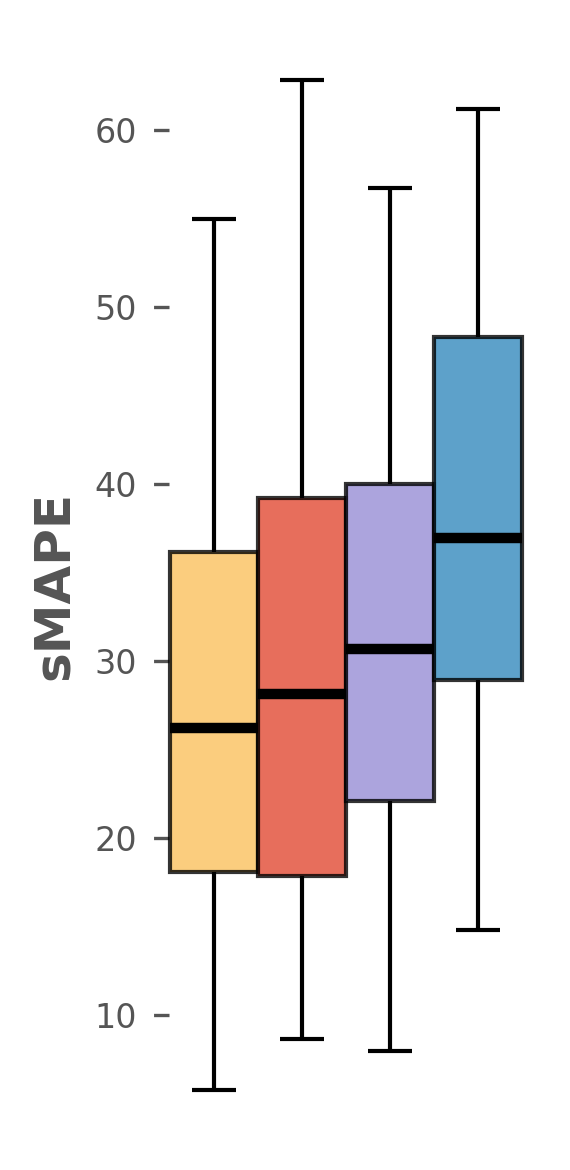

In [87]:
selected_metric = "smape"
legend_handles = make_box_plot(
    unrolled_metrics=unrolled_metrics,
    prediction_length=128,
    metric_to_plot=selected_metric,  # Specify which metric to plot
    sort_runs=True,  # Optionally sort runs by their metric values
    colors=default_colors,
    title=None,
    title_kwargs={"fontsize": 10},
    use_inv_spearman=True,
    order_by_metric="smape",
    save_path=f"{figs_save_dir}/{selected_metric}_128.pdf",
    ylabel_fontsize=12,
    show_xlabel=False,
    box_percentile_range=(25, 75),
    whisker_percentile_range=(5, 95),
    alpha_val=0.8,
    fig_kwargs={"figsize": (2, 4)},
    box_width=1.0,
)

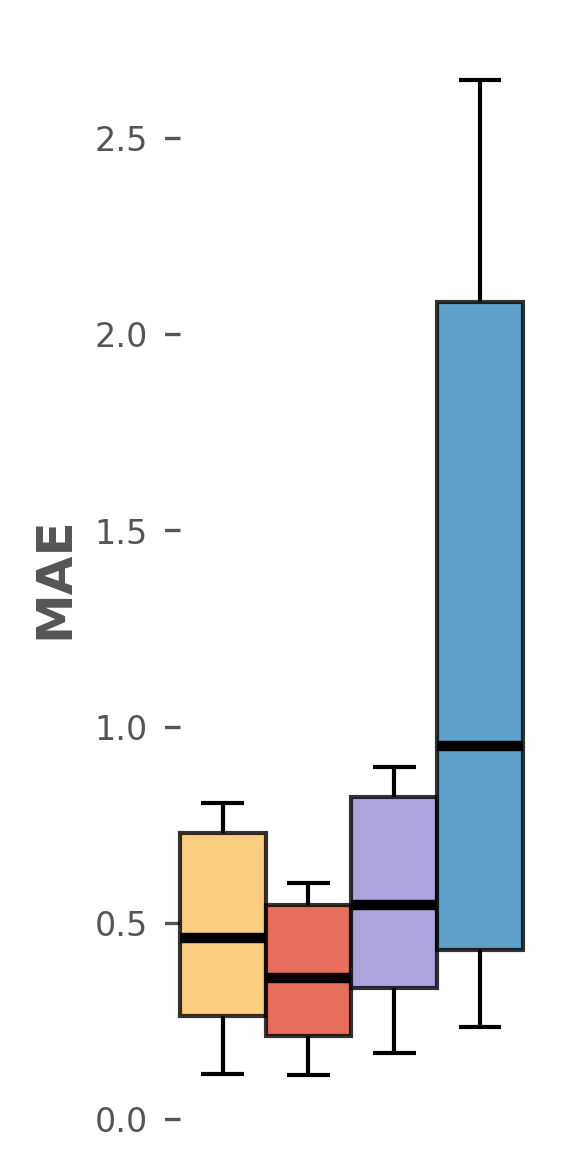

In [88]:
selected_metric = "mae"
legend_handles = make_box_plot(
    unrolled_metrics=unrolled_metrics,
    prediction_length=128,
    metric_to_plot=selected_metric,  # Specify which metric to plot
    sort_runs=True,  # Optionally sort runs by their metric values
    colors=default_colors,
    title=None,
    title_kwargs={"fontsize": 10},
    use_inv_spearman=True,
    order_by_metric="smape",
    save_path=f"{figs_save_dir}/{selected_metric}_128.pdf",
    ylabel_fontsize=12,
    show_xlabel=False,
    box_percentile_range=(25, 75),
    whisker_percentile_range=(10, 80),
    alpha_val=0.8,
    fig_kwargs={"figsize": (2, 4)},
    box_width=1.0,
)

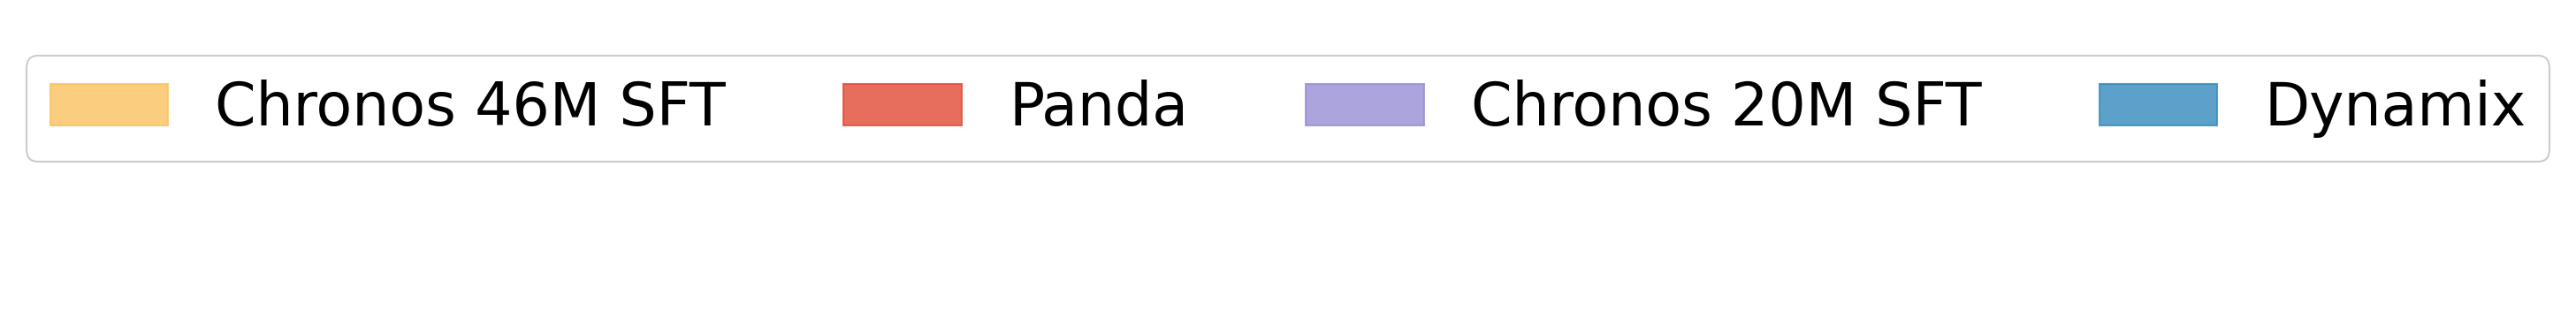

In [89]:
plt.figure(figsize=(6, 1))

# Add the legend with the combined handles
legend = plt.legend(
    handles=legend_handles,
    loc="upper center",
    frameon=True,
    ncol=5,
    framealpha=1.0,
    fontsize=16,
)

plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0)
plt.savefig(f"{figs_save_dir}/baselines_legend_horizontal_patches.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(3, 2))

# Add the legend with the combined handles
legend = plt.legend(
    handles=legend_handles,
    loc="upper center",
    frameon=True,
    ncol=1,
    framealpha=1.0,
    fontsize=16,
)

plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0)
plt.savefig(f"{figs_save_dir}/baselines_legend_vertical_patches.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
smape_metrics_dict, has_nans = get_summary_metrics_dict(unrolled_metrics, "smape")

In [ ]:
metrics = ["mse", "mae", "smape", "spearman"]
metrics_dicts, has_nans = zip(*[get_summary_metrics_dict(unrolled_metrics, metric) for metric in metrics])
all_metrics_dict = {m: metrics_dicts[i] for i, m in enumerate(metrics)}
has_nans_dict = {m: has_nans[i] for i, m in enumerate(metrics)}

In [ ]:
# Count the number of NaNs for each metric and model
nan_counts = {}
for metric_name, metric_data in all_metrics_dict.items():
    nan_counts[metric_name] = {}
    for model_name, model_data in metric_data.items():
        # all_vals = np.concatenate(model_data["all_vals"])
        all_vals_pred128 = model_data["all_vals"][1]
        nan_count = np.isnan(all_vals_pred128).sum()
        nan_counts[metric_name][model_name] = nan_count
        if nan_count > 0:
            print(f"Found {nan_count} NaNs in {model_name} for {metric_name}")

print(nan_counts)

In [ ]:
has_nans_dict

Order model names by sMAPE

In [ ]:
model_names_ordering = []  # sorted by median smape at 128
for model_name, data in all_metrics_dict["smape"].items():
    median_metrics_128 = data["medians"][1]
    model_names_ordering.append((model_name, median_metrics_128))
model_names_ordering = sorted(model_names_ordering, key=lambda x: x[1])
model_names_ordering = [x[0] for x in model_names_ordering]
print(model_names_ordering)

# Reorder all_metrics_dict according to model_names_ordering for each metric
reordered_metrics_dict = {}
for metric_name, metric_data in all_metrics_dict.items():
    reordered_metric_data = {}

    # Add models in the order specified by model_names_ordering
    for model_name in model_names_ordering:
        if model_name in metric_data:
            reordered_metric_data[model_name] = metric_data[model_name]
        else:
            raise ValueError(f"Model {model_name} not found in {metric_name}")

    reordered_metrics_dict[metric_name] = reordered_metric_data
all_metrics_dict = reordered_metrics_dict

In [ ]:
legend_handles = plot_all_metrics_by_prediction_length(
    all_metrics_dict,
    ["mse", "mae", "smape", "spearman"],
    metrics_to_show_envelope=["mae", "smape"],
    n_cols=4,
    n_rows=1,
    save_path=f"{figs_save_dir}/zeroshot_metrics_autoregressive_rollout_metrics.pdf",
    show_legend=False,
    legend_kwargs={"loc": "upper left", "frameon": True, "fontsize": 10},
    colors=default_colors,
    use_inv_spearman=True,
    percentile_range=(40, 60),
    has_nans=has_nans_dict,
)

In [ ]:
plt.figure(figsize=(6, 1))

# Add the legend with the combined handles
legend = plt.legend(
    handles=legend_handles,
    loc="upper center",
    frameon=True,
    ncol=5,
    framealpha=1.0,
    fontsize=16,
)

plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0)
plt.savefig(f"{figs_save_dir}/baselines_legend_horizontal.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(3, 2))

# Add the legend with the combined handles
legend = plt.legend(
    handles=legend_handles,
    loc="upper center",
    frameon=True,
    ncol=1,
    framealpha=1.0,
    fontsize=16,
)

plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0)
plt.savefig(f"{figs_save_dir}/baselines_legend_vertical.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
metric_to_plot = "smape"
plot_all_metrics_by_prediction_length(
    all_metrics_dict,
    [metric_to_plot],
    metrics_to_show_envelope=[metric_to_plot],
    n_cols=1,
    n_rows=1,
    individual_figsize=(4, 4.5),
    save_path=f"{figs_save_dir}/zeroshot_{metric_to_plot}_autoregressive_rollout_metrics.pdf",
    show_legend=False,
    legend_kwargs={"frameon": True, "fontsize": 10, "loc": "lower right"},
    colors=default_colors,
    percentile_range=(40, 60),
    has_nans=has_nans_dict,
)

In [ ]:
metric_to_plot = "mae"
plot_all_metrics_by_prediction_length(
    all_metrics_dict,
    [metric_to_plot],
    metrics_to_show_envelope=[metric_to_plot],
    n_cols=1,
    n_rows=1,
    individual_figsize=(4, 4.5),
    save_path=f"{figs_save_dir}/zeroshot_{metric_to_plot}_autoregressive_rollout_metrics.pdf",
    show_legend=False,
    legend_kwargs={"frameon": True, "fontsize": 10, "loc": "lower right"},
    colors=default_colors,
    percentile_range=(40, 60),
    has_nans=has_nans_dict,
)

In [ ]:
metric_to_plot = "mse"
plot_all_metrics_by_prediction_length(
    all_metrics_dict,
    [metric_to_plot],
    # metrics_to_show_envelope=[metric_to_plot],
    n_cols=1,
    n_rows=1,
    individual_figsize=(4, 4.5),
    save_path=f"{figs_save_dir}/zeroshot_{metric_to_plot}_autoregressive_rollout_metrics.pdf",
    show_legend=False,
    legend_kwargs={"frameon": True, "fontsize": 10, "loc": "lower right"},
    colors=default_colors,
    percentile_range=(40, 60),
    has_nans=has_nans_dict,
)

In [ ]:
metric_to_plot = "spearman"
plot_all_metrics_by_prediction_length(
    all_metrics_dict,
    [metric_to_plot],
    metrics_to_show_envelope=[metric_to_plot],
    n_cols=1,
    n_rows=1,
    individual_figsize=(4, 4.5),
    save_path=f"{figs_save_dir}/zeroshot_{metric_to_plot}_autoregressive_rollout_metrics.pdf",
    show_legend=False,
    legend_kwargs={"frameon": True, "fontsize": 10, "loc": "lower right"},
    colors=default_colors,
    percentile_range=(40, 60),
    has_nans=has_nans_dict,
    use_inv_spearman=True,
)